# Associating fungal effect on plants to genome composition in secreted CAZymes

In [14]:
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import math
import seaborn as sns
from rpy2.robjects import Formula, pandas2ri
from rpy2.robjects.pandas2ri import py2ri
from rpy2.robjects.packages import importr
import rpy2.rinterface
pandas2ri.activate()

%reload_ext rpy2.ipython

## Parse files 

Open plant performance indexes at low phosphate

In [15]:
sfwLow=pd.read_csv('SFW_loP.csv')

Normalize PPI to mock: calculation of Hedges' *g* value (Standard Effect Size)

In [16]:
def R(x, y):
    return stats.pearsonr(x, y)

def getSES(df):
    d=[]
    mock=df[df['Treatment']=='.MOCK']
    for t in set(df['Treatment']):
        if t!='.MOCK':
            treatment=df[df['Treatment']==t]
            SDpooled=math.sqrt(((len(treatment)-1)*(treatment['Performance Index'].std()**2))+((len(mock)-1)*(mock['Performance Index'].std()**2))/(len(treatment)+len(mock)-2))
            hedges=(treatment['Performance Index'].mean()-mock['Performance Index'].mean())/SDpooled
            d.append({'Treatment':t,'Standard Effect Size (Hedges)':hedges})
    return pd.DataFrame(d)

In [17]:
ses=getSES(sfwLow).merge(pd.read_csv('metadata_41strains.csv').rename(index=str,columns={'folder_name':'Treatment'})).set_index('jgi_id')

Open secreted CAZymes table

In [18]:
cazy=pd.read_csv('secretedCAZymes.csv').drop(columns=['Ecology','SpeciesName','Phylum','Class','Order','Family','Genus','Host']).set_index('JGI_ID').merge(ses['Standard Effect Size (Hedges)'],left_index=True,right_index=True)
cazy

,AA1,AA1_1,AA1_2,AA1_3,AA2,AA3,AA3_1,AA3_2,AA3_3,AA4,...,PL14,PL14_3,PL14_4,PL14_5,PL20,PL26,PL27,PL36_2,PL38,Standard Effect Size (Hedges)
Altalt1,1,0,1,4,4,5,3,16,0,0,...,0,0,0,0,0,1,0,0,0,-0.126501
Altro1,1,0,1,3,3,4,3,12,0,0,...,0,0,0,0,0,1,0,0,0,-0.150157
Boeex1,2,0,2,2,6,5,5,12,0,0,...,0,0,0,0,0,1,0,0,0,-0.027370
Chafu1,1,0,1,7,0,3,2,4,0,0,...,0,0,0,0,1,0,0,0,0,0.072577
Chagl1,1,0,1,3,0,3,2,9,0,0,...,0,0,0,0,1,0,0,0,0,0.322120
Chame1,2,0,1,2,1,5,2,9,0,0,...,0,0,0,0,1,0,0,0,0,0.312774
Copph3,0,12,0,0,1,2,1,30,0,0,...,0,0,1,1,0,0,0,0,0,-0.167434
Cylol1,3,0,0,2,1,3,3,2,0,0,...,0,0,0,0,1,1,0,0,0,-0.182092
Daces1,1,0,0,5,1,4,4,5,0,0,...,0,0,0,0,0,1,0,0,0,-0.775455
Dacma1,2,0,0,4,1,3,5,6,0,0,...,0,0,0,0,0,1,0,0,0,-0.504651


## Multiple testing: ANOVA testing the effect of CAZyme counts on PPI at low Phosphate

In [19]:
%%R -i cazy -o adj_ps 
ps <- list()

for (i in names(cazy)) {
    if (i != "Standard.Effect.Size..Hedges.") {
        lm <- lm(paste('Standard.Effect.Size..Hedges.~',i),data=cazy)
        if (shapiro.test(residuals(lm))$p.value >=0.05){
            A <- aov(lm)
        }
        else {
            lm <- lm(paste('log(Standard.Effect.Size..Hedges.)~',i),data=cazy)
            if (shapiro.test(residuals(lm))$p.value >=0.05){
                A <- aov(lm)
            }
            else{ print(i)}
        }
        ps[i]=summary(A)[[1]][["Pr(>F)"]]
    }
}

adj_ps=p.adjust(ps, method = 'bonferroni', n = length(ps))
adj_ps<-data.frame(adj_ps)
adj_ps['name']<-rownames(adj_ps)

Print CAZyme families for which Bonferroni < 0.05

In [20]:
df=adj_ps[adj_ps['adj_ps']<0.05]
df=df.rename(index=str, columns={'adj_ps':'Adj. p-value'})#.set_index('')
df=df.set_index('name')
df

,Adj. p-value
name,
PL1_7,0.026146


## Figure

In [21]:
for i in cazy.index:
    if i in ['Macpha1','Phapo1','Sorhu1','Chame1','Truan1']:
        cazy.loc[i,'Effect at low P']='Beneficial'
    elif i in ['Thacu1','Fustri1','Fusoxy1','Neora1','Ilyeu1','Dacma1','Daces1','Plecucu1']:
        cazy.loc[i,'Effect at low P']='Pathogenic'
    else:
        cazy.loc[i,'Effect at low P']='Neutral'

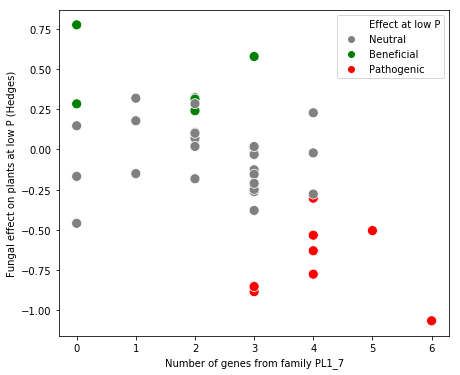

In [22]:
plt.subplots(1,1,figsize=(7,6))
cazy=cazy.rename(index=str, columns={'PL1_7':'Number of genes from family PL1_7','Standard Effect Size (Hedges)':'Fungal effect on plants at low P (Hedges)'})
sns.scatterplot('Number of genes from family PL1_7','Fungal effect on plants at low P (Hedges)',s=100,hue='Effect at low P',palette={'Neutral':'gray','Pathogenic':'red','Beneficial':'green'},data=cazy)

## Multiple testing: ANOVA testing the effect of CAZyme counts on PPI at highPhosphate

Parsing

In [23]:
sfwHi=pd.read_csv('SFW_hiP.csv')
ses=getSES(sfwHi).merge(pd.read_csv('metadata_41strains.csv').rename(index=str,columns={'folder_name':'Treatment'})).set_index('jgi_id')
cazy=pd.read_csv('secretedCAZymes.csv').drop(columns=['Ecology','SpeciesName','Phylum','Class','Order','Family','Genus','Host']).set_index('JGI_ID').merge(ses['Standard Effect Size (Hedges)'],left_index=True,right_index=True)

Testing

In [24]:
%%R -i cazy -o adj_ps 
ps <- list()

for (i in names(cazy)) {
    if (i != "Standard.Effect.Size..Hedges.") {
        lm <- lm(paste('Standard.Effect.Size..Hedges.~',i),data=cazy)
        if (shapiro.test(residuals(lm))$p.value >=0.05){
            A <- aov(lm)
        }
        else {
            lm <- lm(paste('log(Standard.Effect.Size..Hedges.)~',i),data=cazy)
            if (shapiro.test(residuals(lm))$p.value >=0.05){
                A <- aov(lm)
            }
            else{ print(i)}
        }
        ps[i]=summary(A)[[1]][["Pr(>F)"]]
    }
}

adj_ps=p.adjust(ps, method = 'bonferroni', n = length(ps))
adj_ps<-data.frame(adj_ps)
adj_ps['name']<-rownames(adj_ps)

In [25]:
df=adj_ps[adj_ps['adj_ps']<0.05]
df=df.rename(index=str, columns={'adj_ps':'Adj. p-value'})
df=df.set_index('name')
df

,Adj. p-value
name,


No significant association found at high phosphate